## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
((df.group == 'treatment') ^ (df.landing_page == 'new_page')).mean() * df.shape[0]

3893.0

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. 

a. Store your new dataframe in **df2**.

In [8]:
df2=df.drop(index=df[((df.group == 'treatment') ^ (df.landing_page == 'new_page'))== True].index)
df2.reset_index(drop=True, inplace=True)   #filling the gaps in the index

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer some questions.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
duplicated_users=df2[(df2.user_id.duplicated() == True)].user_id.tolist() #getting a list of duplicated users 

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.user_id == duplicated_users]

,user_id,timestamp,group,landing_page,converted
1876,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2862,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.drop_duplicates(subset='user_id', inplace=True)
df2.reset_index(drop=True, inplace=True)   #filling the gaps in the index

`4.` Use **df2** in the cells below to answer some questions.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2.query(" group == 'control'").converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2.query(" group == 'treatment'").converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
df2.query('landing_page == "new_page"').count()[0]/df2.shape[0]

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Old page still has a marginal better conversion rate of (12%) compared to that of new page (11.9%); however, they are too close to conclude that either of them is better than the other.**

<a id='ab_test'></a>
### Part II - A/B Test


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  We can state our hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$ H_0: p_{new}-p_{old} \leq 0 $$
$$ H_1: p_{new}-p_{old} > 0 $$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [18]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [20]:
n_new = df2.query(" group == 'treatment'").count()[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [21]:
n_old = df2.query(" group == 'control'").count()[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.choice([0,1], size=n_new, p=[1-p_new, p_new])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.choice([0,1], size=n_old, p=[1-p_old, p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
new_page_converted.mean() - old_page_converted.mean()

0.0011954251537961424

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [25]:
new_page_converted = np.random.binomial(n_new,p_new,10000)/n_new
old_page_converted = np.random.binomial(n_old,p_old,10000)/n_old
p_diffs = new_page_converted - old_page_converted
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

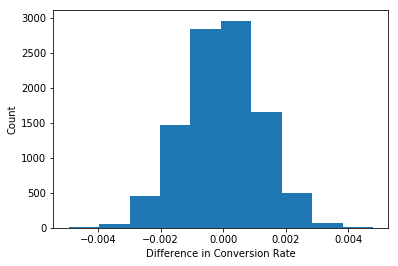

In [26]:
plt.hist(p_diffs);
plt.xlabel('Difference in Conversion Rate');
plt.ylabel('Count');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
obs_diff = df2.query("group == 'treatment'").converted.mean() - df2.query("group == 'control'").converted.mean()
obs_diff #observed difference

-0.0015782389853555567

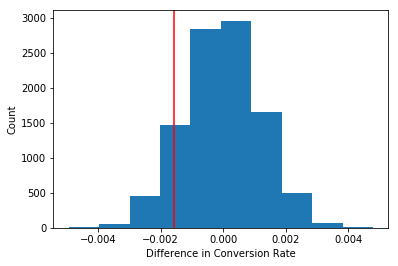

In [28]:
plt.hist(p_diffs);
plt.xlabel('Difference in Conversion Rate');
plt.ylabel('Count');
plt.axvline(obs_diff, color = 'r');

In [29]:
(p_diffs > obs_diff).mean() #p-value

0.90149999999999997

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The value calculated in part j is called the p-value. If it is large, this means that we fail to reject the null and vice versa. Deciding if it is large or small depends on the threshold defined for an analysis.**

**Based on the evidence we have and a Type I error of 5%, we fail to reject the null hypothesis as the p-value is higher than the threshold we assumed at the beginning of our hypothesis test.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [30]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" and converted == 1').count()[0]
convert_new = df2.query('group == "treatment" and converted == 1').count()[0]
n_old = df2.query('group == "control"').count()[0]
n_new = df2.query('group == "treatment"').count()[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [31]:
stat, pval = sm.stats.proportions_ztest([convert_new, convert_old],[n_new, n_old], alternative='larger')
print('p-value = {0:0.3f}\nzstat = {0:0.3f}'.format(pval,stat))

p-value = 0.905
zstat = 0.905


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The results match the ones we computed earlier. The computed z-score and p-value mean that we can't prove that there is a significant difference between the new page and old page in favor of the alternative that is why we fail to reject the null hypothesis.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Conversion is a categorical variable which has two values {0,1} that is why logistic regression is the best choice to predict the outcomes in this case.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
df2['intercept'] = 1 
df2[['ab_page','old_page']] = pd.get_dummies(df2.landing_page) 
df2.drop(columns=['old_page'],axis=1,inplace=True) #we only need ab_page column
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [33]:
logit_model = sm.Logit(df2.converted, df2[['intercept','ab_page']]) # logistic regression model

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [34]:
results = logit_model.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-12-07 09:45 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>


**The p-value associated with ab_page is 0.1899**

**In regression model, the null hypothesis is testing if the coefficients are equal to zero and the alternative is testing if they don't equal to zero which produces two-tailed p-values. However, our hypothesis test in Part II is testing whether the difference is lower than or equal to zero (null) or it is larger than zero (alternative) and it has a one-tailed p-value.**


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?


**Looking at the above regression model, it is apparent that ab_page is not a good predictor of the conversion. So it might be a good idea to add some other factors like time, with different aspects such as weekday, weekend and quarters, and segments of users based on region, country and demographics.**

**However, adding additional factors can make it hard to interpret the results and may even affect their accuracy as the multicollinearity could present in this case and cause unstability of estimates.**


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in.

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns. Provide the statistical output as well as a written response to answer this question.

In [35]:
df3 = pd.read_csv('countries.csv')  #read countries dataset
print(df3.country.unique().tolist())
df3.head()

['UK', 'US', 'CA']


,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [36]:
df4 = df2.join(df3.set_index('user_id'), on='user_id') #join with user-country dataframe

In [37]:
df4 = df4.join(pd.get_dummies(df4.country,drop_first= True)) #creating dummy variables of countries and dropping the first one
df4.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1


In [38]:
logit_model_2 = sm.Logit(df4.converted, df4[['intercept','ab_page','UK','US']]) # logistic regression model
results = logit_model_2.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-12-07 09:45 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

**The p-values of the dummy variables of countries suggest that they are not statistically significant in predicting conversion, and even if they are, there are very small differences in conversion based on which country that the user belongs to; the user from UK and US will be 1.05 times and 1.041 times, respectively, more likely to convert compared to CA.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.

Provide the summary results, and your conclusions based on the results.

In [39]:
#Creating interaction between page and country
df4 ['page_UK'] = df4.ab_page* df4.UK
df4 ['page_US'] = df4.ab_page* df4.US

In [40]:
logit_model_3 = sm.Logit(df4.converted, df4[['intercept','ab_page','UK','US','page_UK','page_US']]) # logistic regression model
results = logit_model_3.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-12-07 09:45 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
page_UK        0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
page_US        0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

**Again, the result suggests that the effect of interaction between page and country is not statistically significant on conversion.**

> **Based on the results of our analysis, we can't confirm any significant differance in conversion based on page, country, or even the interaction between them. It worth pointing out that the data is collected in a period of 22 days which may not be long enough for the results to be accurate and reflect the differences in conversion if exist.**

>**In such case, it is recommended to keep experimenting for a longer period before making any decision.**